In [97]:
import csv
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline, make_pipeline
import sklearn
from sklearn import tree
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import timedelta
from scipy.special import boxcox1p
from scipy import stats
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error


### Importing Libraries

In [98]:
df = pd.read_csv('/content/historical_routes.csv')
df.head()

,DAY_ID,ROUTE_ID,STORE_NUMBER,DAY_OF_WEEK,HELPER,TOTAL_WEIGHT,CASES,URBANITY,UNLOAD_TIME
0,1,1,176,1,False,76.759312,16,U,46.579371
1,4,1,176,4,False,54.218237,11,U,32.698010
2,5,2,176,5,False,80.911549,17,U,49.060463
3,6,5,176,6,False,65.970720,14,U,35.219056
4,8,4,176,1,False,60.334548,13,U,38.351855


In [99]:
# Checking null values
df.isnull().sum()

DAY_ID          0
ROUTE_ID        0
STORE_NUMBER    0
DAY_OF_WEEK     0
HELPER          0
TOTAL_WEIGHT    0
CASES           0
URBANITY        0
UNLOAD_TIME     0
dtype: int64

In [100]:
df.describe()

,DAY_ID,ROUTE_ID,STORE_NUMBER,DAY_OF_WEEK,TOTAL_WEIGHT,CASES,UNLOAD_TIME
count,15321.000000,15321.000000,15321.000000,15321.000000,15321.000000,15321.000000,15321.000000
mean,90.229358,4.173422,90.117486,2.998695,55.872456,11.668821,29.163737
std,51.672604,2.251402,51.981693,1.951534,12.720365,2.560516,9.065642
min,1.000000,1.000000,1.000000,0.000000,10.000000,2.000000,6.000000
25%,45.000000,2.000000,45.000000,1.000000,47.347980,10.000000,22.653633
50%,90.000000,4.000000,90.000000,3.000000,55.905264,12.000000,29.066965
75%,134.000000,6.000000,135.000000,5.000000,64.463454,13.000000,35.264657
max,180.000000,9.000000,180.000000,6.000000,100.000000,20.000000,92.782669


In [101]:
continuous_feature = [feature for feature in df.columns if len(df[feature].unique())>15]
print("Continuous feature Count :{}".format(len(continuous_feature)))
print(continuous_feature)

Continuous feature Count :5
['DAY_ID', 'STORE_NUMBER', 'TOTAL_WEIGHT', 'CASES', 'UNLOAD_TIME']


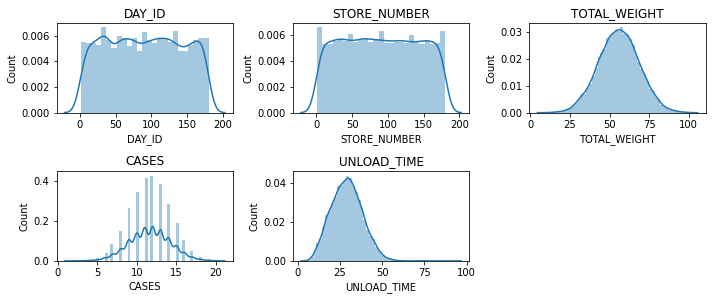

In [102]:
f = plt.figure(figsize = (10,10))
for i, feature in enumerate(continuous_feature):
    f.add_subplot(5, 3, i+1)
    sns.distplot(df[feature])
    plt.tight_layout()
    plt.ylabel("Count")
    plt.title(feature)
plt.show()
warnings.simplefilter(action='ignore', category=FutureWarning)

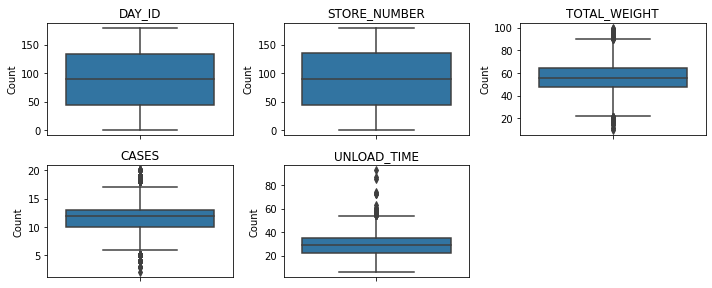

In [103]:
f = plt.figure(figsize = (10,10))
for i, feature in enumerate(continuous_feature):
    f.add_subplot(5, 3, i+1)
    sns.boxplot( y=df[feature])
    plt.tight_layout()
    plt.ylabel("Count")
    plt.title(feature)
plt.show()
warnings.simplefilter(action='ignore', category=FutureWarning)

In [104]:
discrete_feature=[feature for feature in df.columns if len(df[feature].unique())<=15]
print("Discrete Variables Count: {}".format(len(discrete_feature)))

Discrete Variables Count: 4


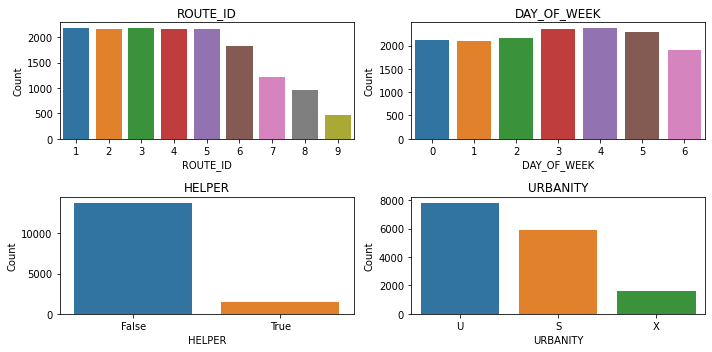

In [105]:
f = plt.figure(figsize = (10,5))
for i, feature in enumerate(discrete_feature):
    f.add_subplot(2, 2, i+1)
    sns.countplot(x = feature, data = df)
    plt.tight_layout()
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.title(feature)
plt.show() 

Text(0.5, 0, 'Unloading time')

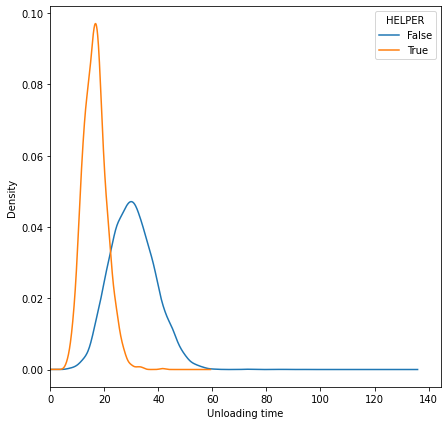

In [106]:
data_help = df.pivot(columns='HELPER',
                     values='UNLOAD_TIME')

data_help.plot.density(figsize = (7, 7))
plt.xlim(left = 0)
plt.xlabel("Unloading time")

Text(0.5, 0, 'Unloading time')

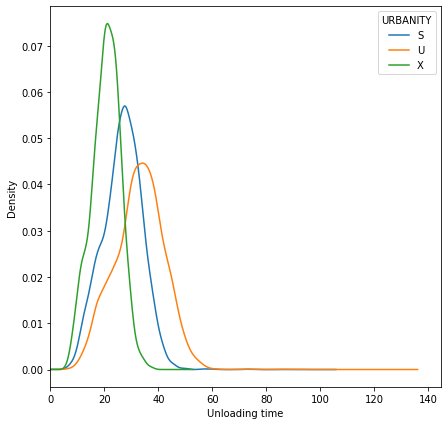

In [107]:
data_urban = df.pivot(columns='URBANITY',
                     values='UNLOAD_TIME')

data_urban.plot.density(figsize = (7, 7))
plt.xlim(left = 0)
plt.xlabel("Unloading time")

# Urban store may have high demand resulting in more stock requirement therefore more unloading time

Text(0.5, 0, 'Unloading time')

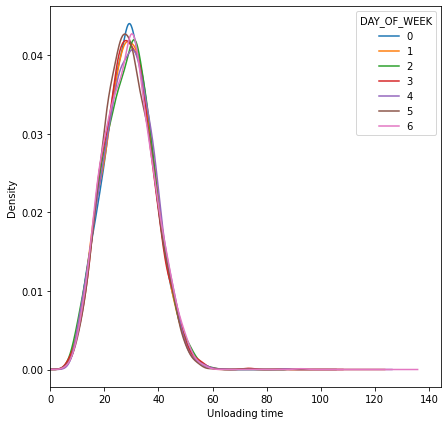

In [108]:
data_week = df.pivot(columns='DAY_OF_WEEK',
                     values='UNLOAD_TIME')

data_week.plot.density(figsize = (7, 7))
plt.xlim(left = 0)
plt.xlabel("Unloading time")

# Constant demand each day of the week

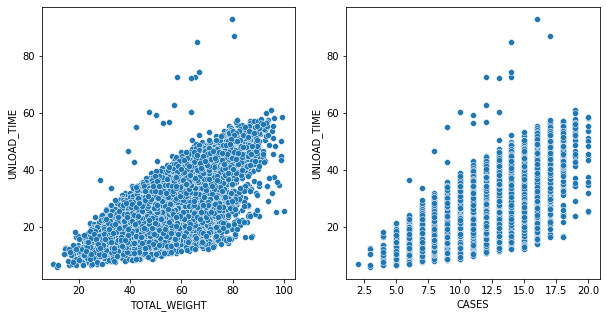

In [109]:
features = [ 'TOTAL_WEIGHT', 'CASES']
fig, ax = plt.subplots(1, 2, figsize = (10,5))

for col, subplot in zip(features , ax.flatten()):
    sns.scatterplot(x=col, y=df['UNLOAD_TIME'], data = df[features] , ax= subplot)
plt.show(fig)

# Positive correleation

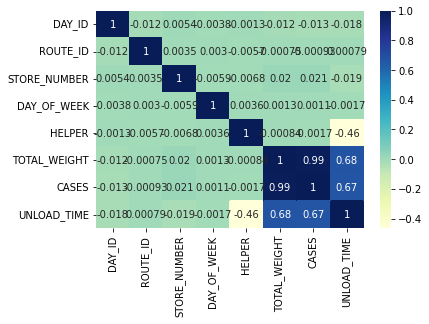

In [111]:
# plotting correlation heatmap
dataplot = sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)
plt.show()

In [112]:
df.drop('CASES', axis = 1, inplace = True)

In [113]:
# Encoding Helper column
df.loc[ df.HELPER == True, 'HELPER'] = 1
df.loc[ df.HELPER == False, 'HELPER'] = 0
df['HELPER'].value_counts()

0    13793
1     1528
Name: HELPER, dtype: int64

In [114]:
# Splitting features into numerical/OHE and Target encoded features
numerical_features = ['HELPER', 'TOTAL_WEIGHT']
ohe_features = ['URBANITY', 'DAY_OF_WEEK', 'ROUTE_ID']
target_encoding_features = ['STORE_NUMBER']
features = numerical_features + ohe_features + target_encoding_features
len(features)

6

In [115]:
# Splitting dependent and independent variables
X = df[features]
Y = df['UNLOAD_TIME']

In [116]:
# Splitting Data between train and test

X_dev, X_test, Y_dev, Y_test = train_test_split(X, Y, test_size=0.20)


In [117]:
preprocess = make_column_transformer((StandardScaler(), numerical_features),
                                      (OneHotEncoder(handle_unknown = "ignore"), ohe_features),
                                      (TargetEncoder(handle_unknown = "ignore"), target_encoding_features),
                                      remainder = 'passthrough')


## Linear Regression

In [118]:
# lr = Pipeline(steps=[('preprocessor', preprocess),
#                       ('classifier', LinearRegression())])

pipe_lr = make_pipeline(preprocess, LinearRegression())

In [119]:
pipe_lr

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['HELPER', 'TOTAL_WEIGHT']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['URBANITY', 'DAY_OF_WEEK',
                                                   'ROUTE_ID']),
                                                 ('targetencoder',
                                                  TargetEncoder(handle_unknown='ignore'),
                                                  ['STORE_NUMBER'])])),
                ('linearregression', LinearRegression())])

In [120]:
pipe_lr.fit(X_dev,Y_dev)
score_dev = pipe_lr.score(X_dev,Y_dev)
score_test = pipe_lr.score(X_test,Y_test)

print('R-squared value on Dev Set is {} and on Test set is {}'.format(score_dev,score_test))

R-squared value on Dev Set is 0.8789351694198371 and on Test set is 0.8786182335668913


In [121]:
# MSE for logistic regression
Y_pred_lr = pipe_lr.predict(X_test)
mse_lr = mean_squared_error(Y_test,Y_pred_lr)

print('MSE value on test set is {}'.format(mse_lr))

MSE value on test set is 9.846912487406549


## Random Forest

In [122]:
param_grid = { 
              'n_estimators': np.arange(10, 160, 20),
              'max_depth': [4,5,6,7,8],
              'min_samples_split': [2,3,4,5]
              }
param_grid

{'n_estimators': array([ 10,  30,  50,  70,  90, 110, 130, 150]),
 'max_depth': [4, 5, 6, 7, 8],
 'min_samples_split': [2, 3, 4, 5]}

In [123]:
pipe_rf = make_pipeline(preprocess,
                    RandomizedSearchCV(RandomForestRegressor(random_state=42),
                                     param_distributions = param_grid, cv = 5
                                     )
                    )

pipe_fit_rf = pipe_rf.fit(X_dev,Y_dev)
random_search_rf = pipe_fit_rf.named_steps["randomizedsearchcv"]

In [124]:
score_dev = pipe_rf.score(X_dev, Y_dev)
score_test = pipe_rf.score(X_test, Y_test)

print("Best Parameters: {}" .format(random_search_rf.best_params_ ))
print("R-squared value on Dev Set is {} and on Test set is {}".format(score_dev,score_test))

Best Parameters: {'n_estimators': 130, 'min_samples_split': 2, 'max_depth': 7}
R-squared value on Dev Set is 0.9131295732383241 and on Test set is 0.9035121825785253


In [125]:
# MSE for Random forest regression
Y_pred_rf = pipe_rf.predict(X_test)
mse_rf = mean_squared_error(Y_test,Y_pred_rf)

print('MSE value on test set is {}'.format(mse_rf))

MSE value on test set is 7.827428469445698


In [126]:
feature_names_ohe = preprocess.named_transformers_["onehotencoder"].get_feature_names().tolist()
feature_names_te = preprocess.named_transformers_["targetencoder"].get_feature_names()
feature_names = numerical_features + feature_names_ohe + feature_names_te 


Text(0, 0.5, 'Feature Importance score')

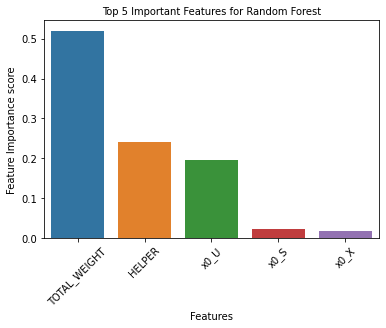

In [127]:
feat_imps = zip(feature_names, random_search_rf.best_estimator_.feature_importances_)
feats, imps = zip(*(sorted(list(filter( lambda x : x[1]!=0 , feat_imps)), key = lambda x : x[1] , reverse=True)))
ax = sns.barplot( list(feats)[:5], list(imps)[:5])
ax.tick_params(axis='x', rotation = 45)
plt.title("Top 5 Important Features for Random Forest", fontsize=10)
plt.xlabel("Features")
plt.ylabel("Feature Importance score")

# XG Boost

In [128]:
param_grid = {
              'n_estimators': np.arange(10, 160, 20),
              'max_depth': [4, 5, 7, 8],
              'learning_rate' : [.01, .1],
              'gamma':[i/10.0 for i in range(0,5)]
              }

In [129]:
pipe_xgb = make_pipeline(preprocess,
                    RandomizedSearchCV( XGBRegressor (random_state=42),
                                     param_distributions = param_grid, cv = 5
                                     )
                    )
pipe_fit_xgb = pipe_xgb.fit(X_dev, Y_dev)

random_search_xgb = pipe_fit_xgb.named_steps["randomizedsearchcv"]


[21:15:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:15:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:15:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:15:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:15:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:15:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:15:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:15:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [130]:
score_dev = pipe_xgb.score(X_dev, Y_dev)
score_test = pipe_xgb.score(X_test, Y_test)

print("Best Parameters: {}" .format(random_search_xgb.best_params_ ))
print("R-squared value on Dev Set is {} and on Test set is {}".format(score_dev,score_test))

Best Parameters: {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.3}
R-squared value on Dev Set is 0.9114099149893289 and on Test set is 0.9032501107364721


In [131]:
# MSE for XGBoost regression
Y_pred_xgb = pipe_xgb.predict(X_test)
mse_xgb = mean_squared_error(Y_test,Y_pred_xgb)

print('MSE value on test set is {}'.format(mse_xgb))

MSE value on test set is 7.848688651843293


Text(0, 0.5, 'Feature Importance')

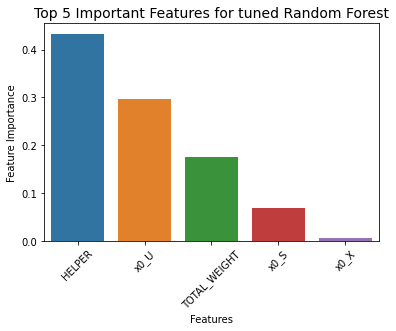

In [132]:
feat_imps = zip(feature_names, random_search_xgb.best_estimator_.feature_importances_)
feats, imps = zip(*(sorted(list(filter( lambda x : x[1]!=0 , feat_imps)), key = lambda x : x[1] , reverse=True)))
ax = sns.barplot( list(feats)[:5], list(imps)[:5])
ax.tick_params(axis='x', rotation = 45)
plt.title("Top 5 Important Features for tuned Random Forest", fontsize=14)
plt.xlabel("Features")
plt.ylabel("Feature Importance")

In [133]:
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [136]:
# MAPE for Logistic regression
lr_mape = MAPE(Y_test,Y_pred_lr)
print("Logistic regression MAPE on test data is: {}".format(lr_mape))

Logistic regression MAPE on test data is: 9.318444595371092


In [137]:
# MAPE for RF regressor
rf_mape = MAPE(Y_test,Y_pred_rf)
print("RF regressor MAPE on test data is: {}".format(rf_mape))

Logistic regression MAPE on test data is: 7.380897920057583


In [139]:
# MAPE for XGB regressor
xgb_mape = MAPE(Y_test,Y_pred_xgb)
print("Logistic regression MAPE on test data is: {}".format(xgb_mape))

Logistic regression MAPE on test data is: 7.346273152768659


QUESTIONS:
1. Intially used all features except UNLOAD TIME but later dropped CASES feature as it was highly correleated with TOTAL_WEIGHT.

Feature engineering included - Scaling of numerical features, Encoding - OHE and Target for categorical features.

2.  Weather Data/ GPS data for route. Store specific packaging data - Dimension of package.

3. Linear regression, Random forest regressor, XGB regressor. Model can be decided using evaluation metrica - R2 value, MSE and MAPE. Moreover, we can also consider model complexitiy, Explanibility while making a decision.

4. Collect more data/Add more features. Include outlier removal, log/box cox transformation as a pre processing step. 